# 1. Importierung der Bibliotheken

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2
import requests
from PIL import Image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# 2. Laden der Trainingsdaten

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


##2.1 Einlesen der Pickle Dateien

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as file:
    train_data = pickle.load(file)
with open('german-traffic-signs/valid.p', 'rb') as file:
    val_data = pickle.load(file)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as file:
    test_data = pickle.load(file)

## 2.2 Aufteilung in Trainings, Validierungs und Test Daten

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

## 2.3 Abfragen ob die Daten im Datensatz die selben Größen besitzen

In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


# 3. Analyse des Datensatzes

## 3.1 Auflistung aller Klassen

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


##3.3 Darstellung aller Klassen mit Beispielbildern

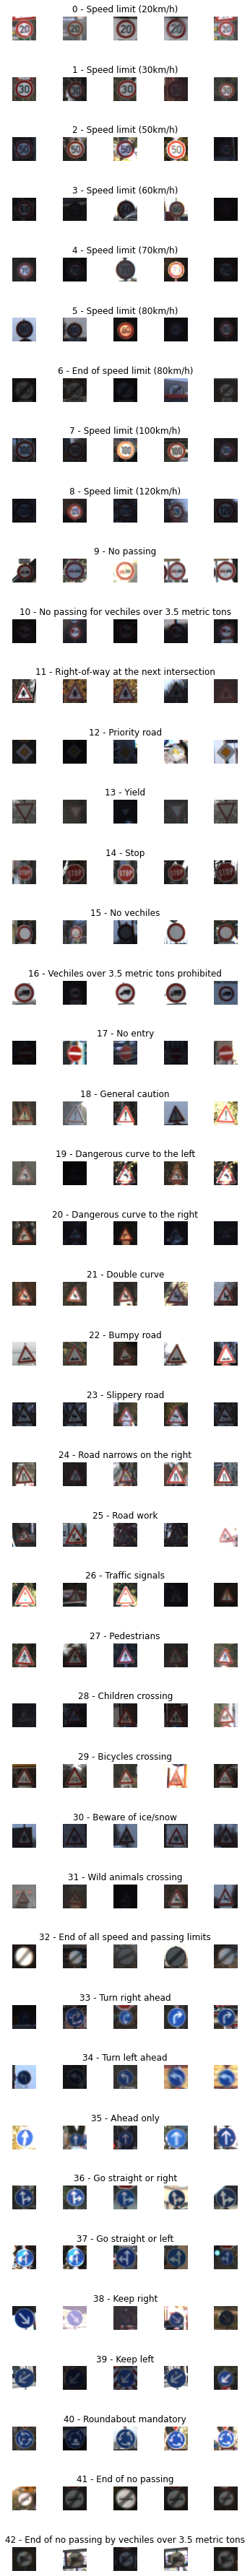

In [ ]:
num_of_samples=[] 
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

##3.3 Darstellung der Verteilung von Bildanzahl zu Klassen

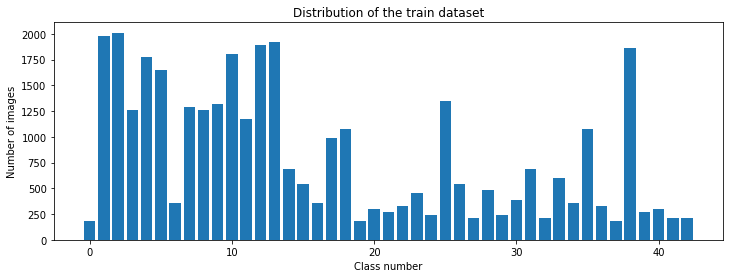

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


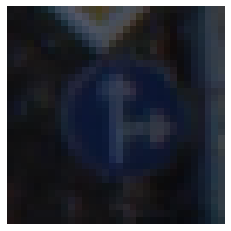

In [ ]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

# 4. Bildbearbeitung

## 4.1 Konvertierung in Graystufe

(32, 32)


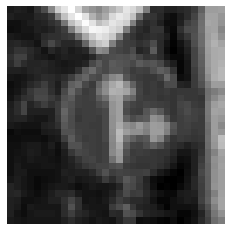

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

## 4.2 Historgrammausgleich

(32, 32)


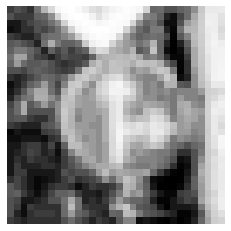

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

## 4.3 Funktion zum Aufruf der Bildbearbeitung

In [ ]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

## 4.4 Mapping

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

##4.5 Darstellung eines bearbeiteten Bildes

9487


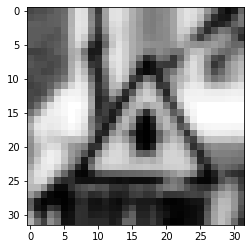

In [ ]:
image_number = random.randint(0, len(X_train) - 1)
print(image_number)

plt.imshow(X_train[image_number], cmap='gray')
#plt.axis('off')


##4.6 Umformung des Arrays

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


##4.7 One hot encoding


In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# 5. Trainings Vorbereitung

## 5.1 Initialisierung eines Image Data Generator
 Dieser fügt den Bildern automatisch die Bild Augmentierungsfunktionen zur Datenerweiterung hinzu.

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

##5.2 Darstellung eines Batches

(15, 32, 32, 1)


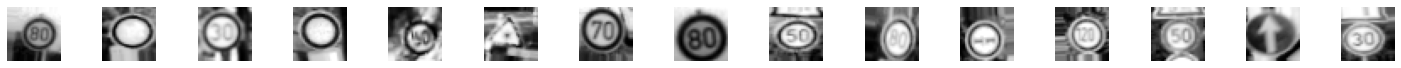

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
    axs[i].axis("off")
 
print(X_batch.shape)

##5.3 Erstellung der Modell Architektur

In [1]:
# create model
 
def model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='elu'))
  model.add(Conv2D(60, (5, 5), activation='elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='elu'))
  model.add(Conv2D(30, (3, 3), activation='elu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(480, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(200, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [4]:
model = model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

# 6. Training und Evaluation

## 6.1 Trainingsprozess

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=500,
                            epochs=15,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/15
500/500 [==============================] - 272s 541ms/step - loss: 1.9077 - accuracy: 0.4525 - val_loss: 0.4802 - val_accuracy: 0.8467
Epoch 2/15
500/500 [==============================] - 271s 542ms/step - loss: 0.9586 - accuracy: 0.7070 - val_loss: 0.2859 - val_accuracy: 0.9045
Epoch 3/15
500/500 [==============================] - 269s 539ms/step - loss: 0.6806 - accuracy: 0.7893 - val_loss: 0.1429 - val_accuracy: 0.9535
Epoch 4/15
500/500 [==============================] - 269s 538ms/step - loss: 0.5424 - accuracy: 0.8368 - val_loss: 0.1104 - val_accuracy: 0.9626
Epoch 5/15
500/500 [==============================] - 269s 537ms/step - loss: 0.4675 - accuracy: 0.8610 - val_loss: 0.1046 - val_accuracy: 0.9678
Epoch 6/15
500/500 [==============================] - 269s 539ms/step - loss: 0.4044 - accuracy: 0.8771 - val_loss: 0.0783 - val_accuracy: 0.9739
Epoch 7/15
500/500 [==============================] - 270s 541ms/step - loss: 0.3546 - accuracy: 0.8963 - val_loss: 0.0910 -

## 6.2 Darstellung der Metriken

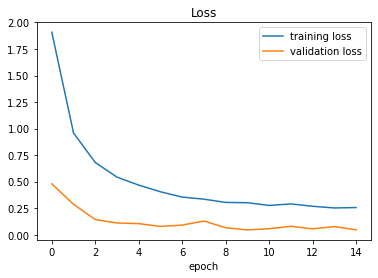

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.xlabel('epoch')
 
plt.legend(['training loss', 'validation loss'])

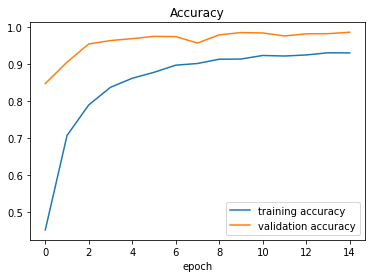

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'])

## 6.3 Evaluation des Modells

In [ ]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13573601841926575
Test accuracy: 0.9638162851333618


## 6.4 Test durch Bilder von Straßenschildern aus dem Internet

Links mit Bildern zum testen

https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg

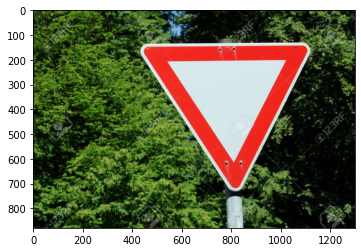

In [ ]:
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


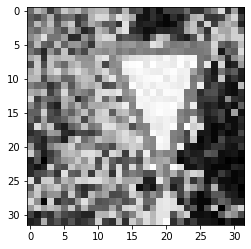

In [ ]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [ ]:
prediction = model.predict(img) 
predicted_class = np.argmax(prediction,axis=1)
print("predicted sign: "+ str(predicted_class))
print(data.iloc[predicted_class])


predicted sign: [13]
    ClassId SignName
13       13    Yield
